In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [164]:
import seaborn as sns
sns.set()

import torch 
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable # storing data while learning
from torch import optim
from torch.utils import data as utilsdata
import torch.nn.functional as F
from torch.distributions import Categorical
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from scipy.signal import argrelmax
from tqdm import tqdm_notebook as tqdm
import scipy

## Create a simple dataset

('X.shape =', (6000, 1))
('X_train.shape =', (4500, 1), 'X_test.shape =', (1500, 1))


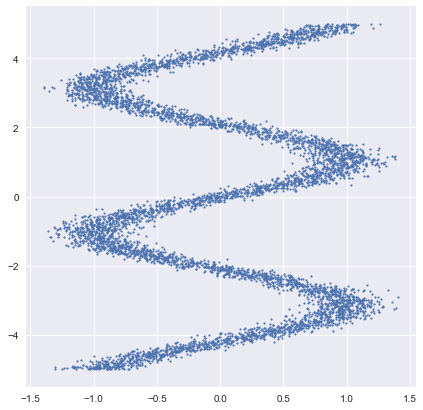

In [6]:
n_samples = 6000
y = np.random.uniform(-5, 5, size=n_samples)
x = np.sin(1.5*y) + np.random.normal(scale=0.15, size=n_samples)
X = x.reshape((-1, 1))
Y = y.reshape((-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)
# create data loaders
batch_size = 50
train = utilsdata.TensorDataset(torch.from_numpy(X_train.astype('float32')),
                                torch.from_numpy(y_train.astype('float32')))
test = utilsdata.TensorDataset(torch.from_numpy(X_test.astype('float32')),
                               torch.from_numpy(y_test.astype('float32')))
train_loader = torch.utils.data.DataLoader(
                 dataset=train,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test,
                batch_size=batch_size,
                shuffle=False)

print('X.shape =', X.shape)
print('X_train.shape =', X_train.shape, 'X_test.shape =', X_test.shape)
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x, y, s=3)

## Define and run the mixture density network

In [7]:
class MixtureDensityNetwork(nn.Module):
    '''Create a mixture density network
    Args:
        n_input: number of input dimensions
        n_hiddens: an integer or a list. Sizes of hidden layers.
        n_output: number of output dimensions
        n_components: number of Gaussian distributions
        logsigma_min, logsigma_max: range to clip log sigma to
    '''
    def __init__(self, n_input = 24, n_hiddens = 10, n_output = 6, 
                 n_components=4, 
                 logsigma_min=-3, logsigma_max=3):
        super(MixtureDensityNetwork, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_components = n_components
        self.n_hiddens = np.atleast_1d(n_hiddens)
        self.logsigma_min = logsigma_min
        self.logsigma_max = logsigma_max
        
        layers = []
        n_hidden_prev = n_input
        for n in self.n_hiddens:
            layers.append(nn.Linear(n_hidden_prev, n))
            layers.append(nn.ReLU())
            n_hidden_prev = n
        layers.append(nn.Linear(n_hidden_prev, n_components*(2*n_output + 1)))
        self.encoder = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.encoder(x)
        logsigma = torch.clamp(0.5*x[:, :self.n_components*self.n_output], 
                            self.logsigma_min, 
                            self.logsigma_max)
        logsigma = logsigma.view(-1, self.n_components, self.n_input)
        mu = x[:, (self.n_components*self.n_output):(self.n_components*self.n_output*2)]
        mu = mu.view(-1, self.n_components, self.n_input)
        logpi = torch.log(self.softmax(x[:, (self.n_components*self.n_output*2):]))
        logpi = logpi.view(-1, self.n_components)
        
        return logpi, logsigma, mu

def mdn_logp(x, logpi, logsigma, mu):
    '''Loss function of a mixture density network is the negative log likelihood of a Gaussian mixture
    Args:
        x: Tensor of shape [batch_size, n_dim]
        logpi: Tensor of shape [batch_size, n_components]
        logsigma: Tensor of shape [batch_size, n_components, n_dim]
        mu: Tensor of shape [batch_size, n_components, n_dim]
    Returns:
        Log likelihoods of input samples. Tensor of shape [batch_size]
    '''
    batch_size, n_components, n_dim = logsigma.size()
    x = x.view(batch_size, -1, n_dim)
    logpi = logpi.view(batch_size, n_components, -1)
    var = torch.pow(torch.exp(logsigma), 2)
    #print(x.size(), logpi.size(), logsigma.size(), mu.size())
    ll_gaussian = -float(0.5*np.log(2*np.pi)) - logsigma - 0.5/var*torch.pow(x - mu, 2)
    ll = torch.logsumexp(ll_gaussian + logpi, 1)
    return ll

def mdn_loss(x, logpi, logsigma, mu):
    '''Same as mdn_logp except that the log likelihoods are negated and averaged across samples
    Returns:
        Negative log likelihood of input samples averaged over samples. A scalar.
    '''
    return torch.mean(-mdn_logp(x, logpi, logsigma, mu))

model = MixtureDensityNetwork(n_input=1, n_output=1, n_components=6, n_hiddens=[10, 10, 10])
optimizer = optim.Adam(model.parameters())

for epoch in range(100):
    train_loss = []
    for i_batch, batch_data in enumerate(train_loader):
        x, y = batch_data
        model.zero_grad()
        logpi, logsigma, mu = model(x) 
        loss = mdn_loss(y, logpi, logsigma, mu)
        loss.backward()
        optimizer.step() 
        train_loss.append(loss.item()*x.size()[0])
    train_loss = np.sum(train_loss)/len(train_loader.dataset)
    test_loss = []
    with torch.no_grad():
        for i_batch, batch_data in enumerate(test_loader):
            x, y = batch_data
            logpi, logsigma, mu = model(x) 
            loss = mdn_loss(y, logpi, logsigma, mu)
            test_loss.append(loss.item()*x.size()[0])
        test_loss = np.sum(test_loss)/len(test_loader.dataset)
    if epoch%10 == 0:
        print('[Epoch {:d}] train loss: {}, test loss: {}'.format(epoch, train_loss, test_loss))

[Epoch 0] train loss: 4.2689504226, test loss: 3.56473939419
[Epoch 10] train loss: 2.05731650723, test loss: 1.96133262714
[Epoch 20] train loss: 1.41014724572, test loss: 1.42139959335
[Epoch 30] train loss: 1.4026753664, test loss: 1.42368338903
[Epoch 40] train loss: 1.40380974412, test loss: 1.41614538431
[Epoch 50] train loss: 1.3955544379, test loss: 1.41605526209
[Epoch 60] train loss: 1.40009430117, test loss: 1.41837778489
[Epoch 70] train loss: 1.39208699862, test loss: 1.40060967207
[Epoch 80] train loss: 1.39248675373, test loss: 1.40278928677
[Epoch 90] train loss: 1.39466784928, test loss: 1.40582970381


## Plot the learned probability densities

(-5, 5)

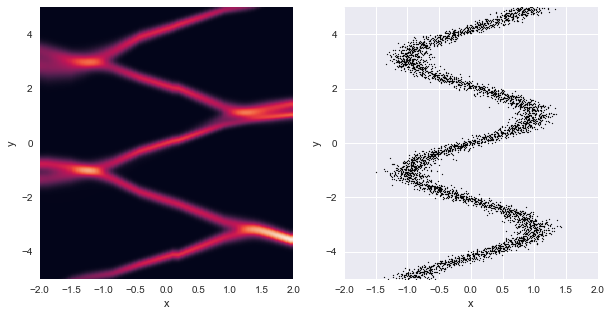

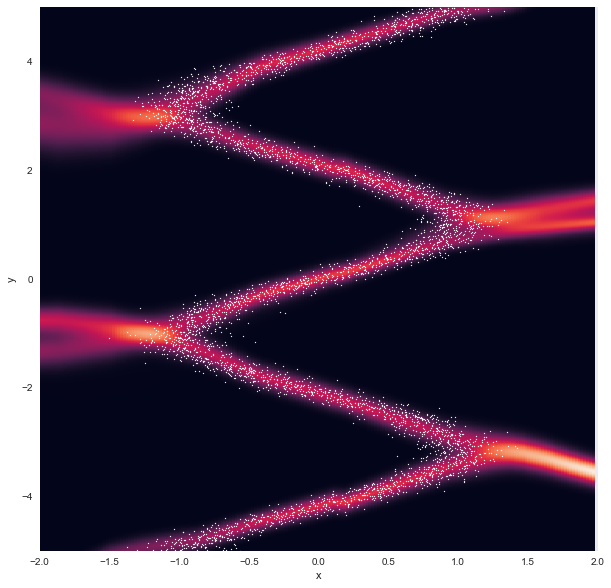

In [152]:
# predict mixture densities
with torch.no_grad():
    X_grid, Y_grid = np.mgrid[-2:2:0.02, -5:5:0.01]
    X_grid = X_grid.T.astype('float32')
    Y_grid = Y_grid.T.astype('float32')
    logpi, logsigma, mu = model(torch.from_numpy(X_grid.reshape(-1, 1)))
    ll = mdn_logp(torch.from_numpy(Y_grid.reshape((-1, 1))), logpi, logsigma, mu)
    p = np.exp(ll.numpy()).reshape(X_grid.shape)
    
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].pcolormesh(X_grid, Y_grid, p)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_xlim(-2, 2)
axes[0].set_ylim(-5, 5)

axes[1].scatter(X_train[:, 0], y_train[:, 0], s=1, c='k')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-5, 5)

fig, ax = plt.subplots(figsize=(10, 10))
ax.pcolormesh(X_grid, Y_grid, p)
ax.scatter(X_train[:, 0], y_train[:, 0], s=1, c='white')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-2, 2)
ax.set_ylim(-5, 5)

## Plot the mixture centers

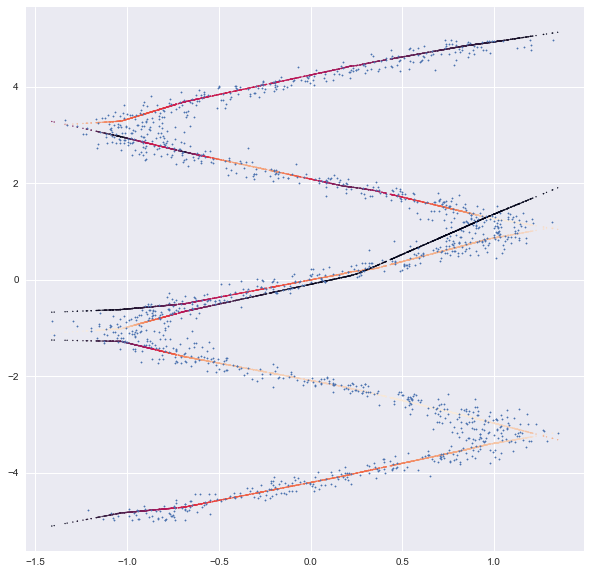

In [120]:
with torch.no_grad():
    logpi, logsigma, mu = model(torch.from_numpy(X_test.astype('float32')))
    pi = np.exp(logpi.data)
    mu = mu.data
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(pi.shape[1]):
    ax.scatter(X_test[:, 0], mu[:, i], c=pi[:, i], s=1)
ax.scatter(X_test[:, 0], y_test[:, 0], s=2)

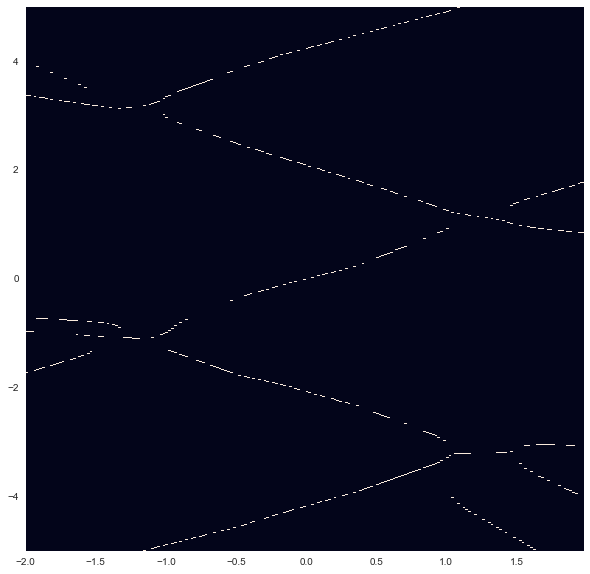

In [143]:
ii, jj = argrelmax(p, axis=0, order=2)
peaks = np.zeros(p.shape, dtype=np.int32)
peaks[ii, jj] = 1
fig, ax = plt.subplots(figsize=(10, 10))
ax.pcolormesh(X_grid, Y_grid, peaks)

### signal dataset

In [9]:
cd /Users/james/signal

/Users/james/signal


In [25]:
def prepare_dataset(featurename='rss'):
    import scipy.io as sio  
    data_1 = sio.loadmat('data_paper_WSNL/1000data.mat')
    data_2 = sio.loadmat('data_paper_WSNL/location.mat')
    local = data_2['RXm'][:1000,:2]
    rss = data_1['data_db_rss']
    aoa = data_1['data_db_aoa']
    toa = data_1['data_db_toa']
    data_4 = data_1['data'][:,18:24]
    data_5 = data_1['data'][:,24:]
    data_6 = data_1['data'][:,6:]
    data_whole = np.concatenate((rss,aoa,toa,data_4,data_5),axis =1)
    local_x = local[:,:1]
    local_y = local[:,1:]
    if featurename=='whole':
        return train_test_split(data_whole, local, random_state=42)
    elif featurename=='rss':
        return train_test_split(rss, local, random_state=42)
    elif featurename=='aoa':
        return train_test_split(aoa, local, random_state=42)
    elif featurename=='toa':
        return train_test_split(toa, local, random_state=42)
    elif featurename=='data_4':
        return train_test_split(data_4, local, random_state=42)
    elif featurename=='data_5':
        return train_test_split(data_5, local, random_state=42)
    elif featurename=='data_6':
        return train_test_split(data_6, local, random_state=42)
X_train, X_test, y_train, y_test = prepare_dataset(featurename='data_6')
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in training data: (750, 24)
Size of output in training data: (750, 2)
Size of features in test data: (250, 24)
Size of output in test data: (250, 2)


In [26]:
class MixtureDensityNetwork(nn.Module):
    '''Create a mixture density network
    Args:
        n_input: number of input dimensions
        n_hiddens: an integer or a list. Sizes of hidden layers.
        n_output: number of output dimensions
        n_components: number of Gaussian distributions
        logsigma_min, logsigma_max: range to clip log sigma to
    '''
    def __init__(self, n_input = 24, n_hiddens = 10, n_output = 6, 
                 n_components=4, 
                 logsigma_min=-3, logsigma_max=3):
        super(MixtureDensityNetwork, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_components = n_components
        self.n_hiddens = np.atleast_1d(n_hiddens)
        self.logsigma_min = logsigma_min
        self.logsigma_max = logsigma_max
        
        layers = []
        n_hidden_prev = n_input
        for n in self.n_hiddens:
            layers.append(nn.Linear(n_hidden_prev, n))
            layers.append(nn.ReLU())
            n_hidden_prev = n
        layers.append(nn.Linear(n_hidden_prev, n_components*(2*n_output + 1)))
        self.encoder = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.encoder(x)
        logsigma = torch.clamp(0.5*x[:, :self.n_components*self.n_output], 
                            self.logsigma_min, 
                            self.logsigma_max)
        logsigma = logsigma.view(-1, self.n_components, self.n_output)
        mu = x[:, (self.n_components*self.n_output):(self.n_components*self.n_output*2)]
        mu = mu.view(-1, self.n_components, self.n_output)
        logpi = torch.log(self.softmax(x[:, (self.n_components*self.n_output*2):]))
        logpi = logpi.view(-1, self.n_components)
        
        return logpi, logsigma, mu

def mdn_logp(x, logpi, logsigma, mu):
    '''Loss function of a mixture density network is the negative log likelihood of a Gaussian mixture
    Args:
        x: Tensor of shape [batch_size, n_dim]
        logpi: Tensor of shape [batch_size, n_components]
        logsigma: Tensor of shape [batch_size, n_components, n_dim]
        mu: Tensor of shape [batch_size, n_components, n_dim]
    Returns:
        Log likelihoods of input samples. Tensor of shape [batch_size]
    '''
    batch_size, n_components, n_dim = logsigma.size()
    x = x.view(batch_size, -1, n_dim)
    logpi = logpi.view(batch_size, n_components, -1)
    var = torch.pow(torch.exp(logsigma), 2)
    #print(x.size(), logpi.size(), logsigma.size(), mu.size())
    ll_gaussian = -float(0.5*np.log(2*np.pi)) - logsigma - 0.5/var*torch.pow(x - mu, 2)
    ll = torch.logsumexp(ll_gaussian + logpi, 1)
    return ll

def mdn_loss(x, logpi, logsigma, mu):
    '''Same as mdn_logp except that the log likelihoods are negated and averaged across samples
    Returns:
        Negative log likelihood of input samples averaged over samples. A scalar.
    '''
    return torch.mean(-mdn_logp(x, logpi, logsigma, mu))

model = MixtureDensityNetwork(n_input=24, n_output=2, n_components=6, n_hiddens=[10, 10, 10])
optimizer = optim.Adam(model.parameters())

In [27]:
model

MixtureDensityNetwork(
  (encoder): Sequential(
    (0): Linear(in_features=24, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=30, bias=True)
  )
  (softmax): Softmax()
)

In [28]:
X_train.shape,y_train.shape

((750, 24), (750, 2))

In [30]:
from sklearn.preprocessing import MinMaxScaler
def preprocess(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    return scaler.transform(data),scaler
scalers = {}
datas = [X_train, X_test, y_train, y_test]
for i in range(4):
    datas[i],scalers[i]  = preprocess(datas[i])
X_train_, X_test_, y_train_, y_test_ = datas

In [23]:
# create data loaders
batch_size = 20
train = utilsdata.TensorDataset(torch.from_numpy(X_train.astype('float32')),
                                torch.from_numpy(y_train.astype('float32')))
test = utilsdata.TensorDataset(torch.from_numpy(X_test.astype('float32')),
                               torch.from_numpy(y_test.astype('float32')))
train_loader = torch.utils.data.DataLoader(
                 dataset=train,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test,
                batch_size=batch_size,
                shuffle=False)

#print('X.shape =', X.shape)
print('X_train.shape =', X_train.shape, 'X_test.shape =', X_test.shape)
#fig, ax = plt.subplots(figsize=(7, 7))
#ax.scatter(x, y, s=3)

('X_train.shape =', (750, 24), 'X_test.shape =', (250, 24))


In [31]:
# create data loaders
batch_size = 20
train_ = utilsdata.TensorDataset(torch.from_numpy(X_train_.astype('float32')),
                                torch.from_numpy(y_train_.astype('float32')))
test_ = utilsdata.TensorDataset(torch.from_numpy(X_test_.astype('float32')),
                               torch.from_numpy(y_test_.astype('float32')))
train_loader_ = torch.utils.data.DataLoader(
                 dataset=train_,
                 batch_size=batch_size,
                 shuffle=True)
test_loader_ = torch.utils.data.DataLoader(
                dataset=test_,
                batch_size=batch_size,
                shuffle=False)

#print('X.shape =', X.shape)
print('X_train.shape =', X_train.shape, 'X_test.shape =', X_test.shape)
#fig, ax = plt.subplots(figsize=(7, 7))
#ax.scatter(x, y, s=3)

('X_train.shape =', (750, 24), 'X_test.shape =', (250, 24))


In [32]:
for epoch in tqdm(range(10000)):
    train_loss = []
    for i_batch, batch_data in enumerate(train_loader_):
        x, y = batch_data
        model.zero_grad()
        logpi, logsigma, mu = model(x) 
        loss = mdn_loss(y, logpi, logsigma, mu)
        loss.backward()
        optimizer.step() 
        train_loss.append(loss.item()*x.size()[0])
    train_loss = np.sum(train_loss)/len(train_loader.dataset)
    test_loss = []
    with torch.no_grad():
        for i_batch, batch_data in enumerate(test_loader_):
            x, y = batch_data
            logpi, logsigma, mu = model(x) 
            loss = mdn_loss(y, logpi, logsigma, mu)
            test_loss.append(loss.item()*x.size()[0])
        test_loss = np.sum(test_loss)/len(test_loader.dataset)
    if epoch%10 == 0:
        print('[Epoch {:d}] train loss: {}, test loss: {}'.format(epoch, train_loss, test_loss))

HBox(children=(IntProgress(value=0, max=10000), HTML(value=u'')))

[Epoch 0] train loss: 1.0281291302, test loss: 0.968493578434
[Epoch 10] train loss: -0.58197833697, test loss: -0.624759988785
[Epoch 20] train loss: -1.21390760899, test loss: -0.88372522831
[Epoch 30] train loss: -1.47735711575, test loss: -1.22689176083
[Epoch 40] train loss: -1.59607830524, test loss: -1.42480722427
[Epoch 50] train loss: -1.65493857066, test loss: -1.25768459558
[Epoch 60] train loss: -1.6863714091, test loss: -1.37113935471
[Epoch 70] train loss: -1.71495412985, test loss: -1.41734294415
[Epoch 80] train loss: -1.74500162284, test loss: -1.47967949867
[Epoch 90] train loss: -1.7687463061, test loss: -1.44688512802
[Epoch 100] train loss: -1.78407684644, test loss: -1.5644974947
[Epoch 110] train loss: -1.79207834244, test loss: -1.32617024899
[Epoch 120] train loss: -1.81440908591, test loss: -1.54824055672
[Epoch 130] train loss: -1.81480612437, test loss: -1.49886236668
[Epoch 140] train loss: -1.83514942646, test loss: -1.54367557049
[Epoch 150] train loss: -

[Epoch 1250] train loss: -2.00705455462, test loss: -1.66822417736
[Epoch 1260] train loss: -2.01590531667, test loss: -1.62556453228
[Epoch 1270] train loss: -2.01750892957, test loss: -1.57162414551
[Epoch 1280] train loss: -2.0117371432, test loss: -1.61423336029
[Epoch 1290] train loss: -2.01413081487, test loss: -1.61833282948
[Epoch 1300] train loss: -2.01497776031, test loss: -1.62186871529
[Epoch 1310] train loss: -2.01148169518, test loss: -1.5995359993
[Epoch 1320] train loss: -2.01741234461, test loss: -1.58522400856
[Epoch 1330] train loss: -2.01976277351, test loss: -1.56451061249
[Epoch 1340] train loss: -2.01377897263, test loss: -1.54282836437
[Epoch 1350] train loss: -2.02048447609, test loss: -1.58625727654
[Epoch 1360] train loss: -2.01719555855, test loss: -1.62592460632
[Epoch 1370] train loss: -2.01607292811, test loss: -1.59341083527
[Epoch 1380] train loss: -2.01919054985, test loss: -1.5888995266
[Epoch 1390] train loss: -2.01903910478, test loss: -1.6272263050

[Epoch 2480] train loss: -2.03627732277, test loss: -1.5914309454
[Epoch 2490] train loss: -2.03758793513, test loss: -1.57884126663
[Epoch 2500] train loss: -2.03875163714, test loss: -1.63960797787
[Epoch 2510] train loss: -2.04071818034, test loss: -1.60039780617
[Epoch 2520] train loss: -2.03785195351, test loss: -1.57741803169
[Epoch 2530] train loss: -2.04136111259, test loss: -1.6210461998
[Epoch 2540] train loss: -2.04003881137, test loss: -1.62414307594
[Epoch 2550] train loss: -2.03572478135, test loss: -1.63277555466
[Epoch 2560] train loss: -2.03749176025, test loss: -1.54453166008
[Epoch 2570] train loss: -2.03427099069, test loss: -1.59145134449
[Epoch 2580] train loss: -2.04025827408, test loss: -1.60423609257
[Epoch 2590] train loss: -2.04094860077, test loss: -1.63266011715
[Epoch 2600] train loss: -2.03518691699, test loss: -1.61569810867
[Epoch 2610] train loss: -2.0420270443, test loss: -1.64786146164
[Epoch 2620] train loss: -2.03614940961, test loss: -1.5744606447

[Epoch 3710] train loss: -2.04815524101, test loss: -1.65891674519
[Epoch 3720] train loss: -2.04913208961, test loss: -1.64821683884
[Epoch 3730] train loss: -2.04824008624, test loss: -1.61062761784
[Epoch 3740] train loss: -2.04690144539, test loss: -1.68560038567
[Epoch 3750] train loss: -2.04938164711, test loss: -1.73010972977
[Epoch 3760] train loss: -2.0510592556, test loss: -1.7259643364
[Epoch 3770] train loss: -2.0503635184, test loss: -1.68781703472
[Epoch 3780] train loss: -2.05057733854, test loss: -1.66479919434
[Epoch 3790] train loss: -2.04689785957, test loss: -1.69570723057
[Epoch 3800] train loss: -2.04815577507, test loss: -1.6512182188
[Epoch 3810] train loss: -2.04878400803, test loss: -1.67268279552
[Epoch 3820] train loss: -2.05023970286, test loss: -1.69685019493
[Epoch 3830] train loss: -2.05174876531, test loss: -1.69831468105
[Epoch 3840] train loss: -2.05062573115, test loss: -1.72450156212
[Epoch 3850] train loss: -2.0515972805, test loss: -1.73476994991


[Epoch 4940] train loss: -2.05344418208, test loss: -1.73039306164
[Epoch 4950] train loss: -2.05197821299, test loss: -1.70717047215
[Epoch 4960] train loss: -2.05160995483, test loss: -1.74935657024
[Epoch 4970] train loss: -2.05377410253, test loss: -1.6845780468
[Epoch 4980] train loss: -2.0478638649, test loss: -1.72627840042
[Epoch 4990] train loss: -2.05017123222, test loss: -1.72045554161
[Epoch 5000] train loss: -2.05410886129, test loss: -1.67724127769
[Epoch 5010] train loss: -2.05194005013, test loss: -1.70103965759
[Epoch 5020] train loss: -2.05307052612, test loss: -1.71597708702
[Epoch 5030] train loss: -2.04922478676, test loss: -1.75950814247
[Epoch 5040] train loss: -2.05011330287, test loss: -1.73854301453
[Epoch 5050] train loss: -2.05229760806, test loss: -1.70681694984
[Epoch 5060] train loss: -2.05160083135, test loss: -1.64044657707
[Epoch 5070] train loss: -2.05365496635, test loss: -1.69899199963
[Epoch 5080] train loss: -2.05319509506, test loss: -1.656358680

[Epoch 6170] train loss: -2.05492495855, test loss: -1.70905947685
[Epoch 6180] train loss: -2.05126875242, test loss: -1.71693989754
[Epoch 6190] train loss: -2.05416304906, test loss: -1.69740736008
[Epoch 6200] train loss: -2.05447229385, test loss: -1.70807501793
[Epoch 6210] train loss: -2.05411159197, test loss: -1.7000442791
[Epoch 6220] train loss: -2.05567071915, test loss: -1.73298774719
[Epoch 6230] train loss: -2.05560590108, test loss: -1.70878647804
[Epoch 6240] train loss: -2.0560440286, test loss: -1.69922904968
[Epoch 6250] train loss: -2.05385901451, test loss: -1.67641649723
[Epoch 6260] train loss: -2.05425836881, test loss: -1.67930751801
[Epoch 6270] train loss: -2.05322237333, test loss: -1.73563657284
[Epoch 6280] train loss: -2.05699046453, test loss: -1.6903063488
[Epoch 6290] train loss: -2.05562650363, test loss: -1.66454493046
[Epoch 6300] train loss: -2.05256891886, test loss: -1.74168073654
[Epoch 6310] train loss: -2.05459586143, test loss: -1.7358433675

[Epoch 7400] train loss: -2.05350758235, test loss: -1.70642561913
[Epoch 7410] train loss: -2.05323898951, test loss: -1.64696608543
[Epoch 7420] train loss: -2.05314679305, test loss: -1.71918179035
[Epoch 7430] train loss: -2.05826613744, test loss: -1.71965402603
[Epoch 7440] train loss: -2.0547512722, test loss: -1.71769441128
[Epoch 7450] train loss: -2.05708240509, test loss: -1.66430473328
[Epoch 7460] train loss: -2.05648990949, test loss: -1.63579091072
[Epoch 7470] train loss: -2.05647637049, test loss: -1.70571006298
[Epoch 7480] train loss: -2.05610524813, test loss: -1.71087275982
[Epoch 7490] train loss: -2.05749478976, test loss: -1.68895592213
[Epoch 7500] train loss: -2.05756262143, test loss: -1.69084350586
[Epoch 7510] train loss: -2.05742003759, test loss: -1.71401158333
[Epoch 7520] train loss: -2.05504284859, test loss: -1.63045855045
[Epoch 7530] train loss: -2.0567503341, test loss: -1.68785398006
[Epoch 7540] train loss: -2.05677865028, test loss: -1.714291090

[Epoch 8630] train loss: -2.0614167436, test loss: -1.65895151138
[Epoch 8640] train loss: -2.05884662628, test loss: -1.62728574276
[Epoch 8650] train loss: -2.05967055957, test loss: -1.66000226021
[Epoch 8660] train loss: -2.06103838285, test loss: -1.60260258675
[Epoch 8670] train loss: -2.06150779406, test loss: -1.64773560524
[Epoch 8680] train loss: -2.06089567184, test loss: -1.65443816185
[Epoch 8690] train loss: -2.05860712051, test loss: -1.64201844692
[Epoch 8700] train loss: -2.05964386304, test loss: -1.67633210182
[Epoch 8710] train loss: -2.06032974243, test loss: -1.63617563248
[Epoch 8720] train loss: -2.06206451734, test loss: -1.64644736767
[Epoch 8730] train loss: -2.06019071579, test loss: -1.61332368851
[Epoch 8740] train loss: -2.0602465121, test loss: -1.63211603642
[Epoch 8750] train loss: -2.06192766507, test loss: -1.57893373489
[Epoch 8760] train loss: -2.06211993217, test loss: -1.61909992695
[Epoch 8770] train loss: -2.06131620407, test loss: -1.646918048

[Epoch 9860] train loss: -2.06265975316, test loss: -1.65947105885
[Epoch 9870] train loss: -2.06021268527, test loss: -1.59134358883
[Epoch 9880] train loss: -2.05943647067, test loss: -1.61611245632
[Epoch 9890] train loss: -2.0637191391, test loss: -1.60990645885
[Epoch 9900] train loss: -2.06423666954, test loss: -1.64679748058
[Epoch 9910] train loss: -2.06087938944, test loss: -1.69708356857
[Epoch 9920] train loss: -2.06146630923, test loss: -1.58671783924
[Epoch 9930] train loss: -2.06320180257, test loss: -1.6461706543
[Epoch 9940] train loss: -2.06340033213, test loss: -1.58605817318
[Epoch 9950] train loss: -2.06298544566, test loss: -1.55908967018
[Epoch 9960] train loss: -2.06305450757, test loss: -1.59945970535
[Epoch 9970] train loss: -2.06392971039, test loss: -1.61857129097
[Epoch 9980] train loss: -2.06263039589, test loss: -1.66901665211
[Epoch 9990] train loss: -2.06158465068, test loss: -1.58367379189


In [35]:
logpi_pred, logsigma_pred, mu_pred = model(torch.Tensor(X_test_))

In [38]:
logpi_pred.size(), logsigma_pred.size(), mu_pred.size()

(torch.Size([250, 6]), torch.Size([250, 6, 2]), torch.Size([250, 6, 2]))

In [30]:
logpi.size()
ll.shape,X_test_.shape
ll = mdn_logp(torch.Tensor(y_test_.reshape((-1, 1))), torch.Tensor(logpi), torch.Tensor(logsigma), torch.Tensor(mu))
p = np.exp(ll.detach().numpy()).reshape(y_test_.shape)

torch.Size([250, 6])

In [65]:
def get_original_parameters(logpi, logsigma, mu):
    '''
    input scaled and logged
    output exped, not reversed yet 
    '''
    pi = np.exp(logpi.detach().numpy())
    sigma = np.exp(logsigma.detach().numpy())
    mu = mu.detach().numpy()
    return pi, sigma, mu

In [66]:
pi_reversed, sigma_reversed, mu_reversed = get_original_parameters(logpi_pred, logsigma_pred, mu_pred)

In [67]:
pi_reversed.shape, sigma_reversed.shape, mu_reversed.shape

((250, 6), (250, 6, 2), (250, 6, 2))

In [70]:
class IsotropicGaussianMixture(object):
    def __init__(self, n_components=2, n_dim=1):
        self.n_components = n_components
        self.n_dim = n_dim
        self.pi = np.full(n_components, 1.0/n_components)
        self.sigma = np.ones((n_components, n_dim))
        self.mu = np.zeros((n_components, n_dim))
    
    def init_params(self):
        self.pi = np.random.dirichlet(alpha=[0.8]*self.n_components)
        self.mu = np.random.uniform(-3, 3, size=(self.n_components, self.n_dim))
        self.sigma = np.sqrt(np.random.gamma(shape=1, size=(self.n_components, self.n_dim)))
        return self
    
    def set_params(self, pi=None, mu=None, sigma=None):
        if pi is not None:
            self.pi = pi
        if mu is not None:
            self.mu = mu
        if sigma is not None:
            self.sigma = sigma
        #print (self.pi,self.mu,self.sigma)
        return self
    
    def pdf(self, x):
        '''Calculate probability density of given points
        Args:
            x: ndarray of shape [n_dim] or [n_samples, n_dim]
        Returns:
            p: probality densities of given points
                if x is an ndarray of shape [n_dim], p is a scalar
                if x is an ndarray of shape [n_samples, n_dim], p is a 
        '''
        K, D = self.n_components, self.n_dim
        x = np.atleast_1d(x)
        if len(x.shape) == 1:
            assert x.shape[0] == D
            x = x.reshape((1, D))
            p_c = 1.0/np.power(2*np.pi, 0.5*D)/np.prod(self.sigma, axis=-1)
            p_c *= np.exp(-0.5*np.sum(np.square((x - self.mu)/self.sigma), axis=-1))
            p = np.sum(self.pi*p_c, axis=-1)
        else:
            assert x.shape[1] == D
            N = x.shape[0]
            x = x.reshape((N, 1, D))
            pi = self.pi.reshape((1, K))
            sigma = self.sigma.reshape((1, K, D))
            mu = self.mu.reshape((1, K, D))
            p_c = 1.0/np.power(2*np.pi, 0.5*D)/np.prod(sigma, axis=-1)
            p_c = p_c*np.exp(-0.5*np.sum(np.square((x - mu)/sigma), axis=-1))
            p = np.sum(pi*p_c, axis=-1)
        return p

    def __repr__(self):
        s = []
        s.append('n_components = {}'.format(self.n_components))
        s.append('n_dim = {}'.format(self.n_dim))
        s.append('pi = [{}]'.format(', '.join(self.pi.astype('str'))))
        for i in range(self.n_components):
            s.append('  mu[{:d}] = [{}]'.format(i, ', '.join(self.mu[i].astype('str'))))
            s.append('  sigma[{:d}] = [{}]'.format(i, ', '.join(self.sigma[i].astype('str'))))
        return '\n'.join(s)
    
    def mean_shift(self, x, tol=1e-6):
        '''Run mean-shift algorithm to find a mode
        Args:
            x: initial guess for a mode
            tol: absolute error in modes between iterations for defining convergence
        Returns:
            mode: ndarray of shape [n_dim]. Mode found.
        '''
        K, D = self.n_components, self.n_dim
        
        x_old = x
        while True:
            kernel = self.pi.reshape((K, 1))/np.prod(self.sigma, axis=1, keepdims=True)/np.square(self.sigma)
            kernel *= np.exp(-0.5*np.sum(np.square((x.reshape((1, D)) - self.mu)/self.sigma), axis=-1)).reshape((K, 1))
            x = np.sum(kernel*self.mu, axis=0)/np.sum(kernel, axis=0)
            if np.sqrt(np.sum(np.abs(x - x_old))) < tol:
                break
            x_old = x
        return x

    def find_modes(self, n_init=10, tol_mean_shift=1e-6, tol_merge_modes=1e-3):
        '''Find modes in the gaussian mixture model
        Args:
            n_init: number of random initializations
            tol_mean_shift: absolute error in modes between iterations for defining convergence
            tol_merge_modes: absolute error between modes for merging modes
        Returns:
            modes: ndarray of shape [n_modes, n_dim]. Modes found.
        '''
        K, D = self.n_components, self.n_dim
        # set range of high density region for finding modes
        #print self.mu, self.sigma
        range_min = np.min(self.mu - self.sigma)
        range_max = np.max(self.mu + self.sigma)
        modes = np.empty((0, D))
        for i in range(n_init):
            x = np.random.uniform(range_min, range_max, size=D)
            x_old = x
            n_iter = 0
            while True:
                n_iter += 1
                kernel = self.pi.reshape((K, 1))/np.prod(self.sigma, axis=1, keepdims=True)/np.square(self.sigma)
                kernel *= np.exp(-0.5*np.sum(np.square((x.reshape((1, D)) - self.mu)/self.sigma), axis=-1)).reshape((K, 1))
                x = np.sum(kernel*self.mu, axis=0)/np.sum(kernel, axis=0)
                if np.sum(np.abs(x - x_old)) < tol_mean_shift:
                    break
                x_old = x
            if len(modes) == 0:
                modes = np.append(modes, x.reshape((1, D)), axis=0)
            else:
                if np.min(np.sum(np.abs(x.reshape((1, D)) - modes), axis=1)) > tol_merge_modes:
                    modes = np.append(modes, x.reshape((1, D)), axis=0)
        return modes

In [154]:
def get_prediction(pi,mu,sigma):
    model = IsotropicGaussianMixture(n_components=6, n_dim=2)
    model.set_params(pi,mu,sigma)
    modes = model.find_modes(n_init=10)
    p_modes = model.pdf(modes)
    #print p_modes,modes
    index=np.where(p_modes==np.max(p_modes))
    return p_modes[index[0]], modes[index[0]]

In [144]:
ind = 150
get_prediction(pi_reversed[ind], mu_reversed[ind],sigma_reversed[ind])

[64.20768913] [[ 0.70430243 -0.04896909]]


(array([64.20768913]), array([[ 0.70430243, -0.04896909]]))

In [152]:
get_prediction(pi_reversed[0], mu_reversed[0],sigma_reversed[0])[1]

[64.20769033] [[0.45747054 0.22072813]]


array([[0.45747054, 0.22072813]])

In [142]:
scalers[3].inverse_transform(get_prediction(pi_reversed[0], sigma_reversed[0], mu_reversed[0])[0].reshape(-1,1))

[1.57615645] [[0.04978706 0.04978707]]


ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,2)

In [149]:
def plot_result(ax,ind):
    gaussianmodel = IsotropicGaussianMixture(n_components=6, n_dim=2)
    gaussianmodel.set_params(pi_reversed[ind],  mu_reversed[ind], sigma_reversed[ind])
    X_grid, Y_grid = np.mgrid[-5:5:0.02, -5:5:0.02]
    X = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
    modes = gaussianmodel.find_modes(n_init=10)
    print ('modes',modes)
    print ('p_modes',gaussianmodel.pdf(modes))
    ax.contour(X_grid, Y_grid, gaussianmodel.pdf(X).reshape(X_grid.shape), 
                   linewidths=0.5, levels=np.linspace(0, 1, 80))

('modes', array([[ 0.70430243, -0.04896909]]))
('p_modes', array([64.20768913]))
('modes', array([[0.36988398, 0.48034799]]))
('p_modes', array([64.20769033]))
('modes', array([[0.61332381, 0.78293431]]))
('p_modes', array([64.20768794]))
('modes', array([[0.97048539, 0.3809537 ]]))
('p_modes', array([64.20768777]))
('modes', array([[ 0.83280391, -0.00546647]]))
('p_modes', array([64.20768831]))
('modes', array([[0.46827072, 0.83842462]]))
('p_modes', array([64.20768786]))
('modes', array([[0.14829551, 0.11088226]]))
('p_modes', array([64.20768359]))
('modes', array([[0.66282529, 0.41545078],
       [0.69266337, 0.85098672]]))
('p_modes', array([2.90081119e-11, 6.42076876e+01]))
('modes', array([[0.77500033, 0.73229098]]))
('p_modes', array([64.20768768]))
('modes', array([[0.3628841 , 0.87671578]]))
('p_modes', array([64.20768757]))
('modes', array([[ 0.55960244, -0.01052147]]))
('p_modes', array([64.20769068]))
('modes', array([[0.94109082, 0.00737077]]))
('p_modes', array([64.207688

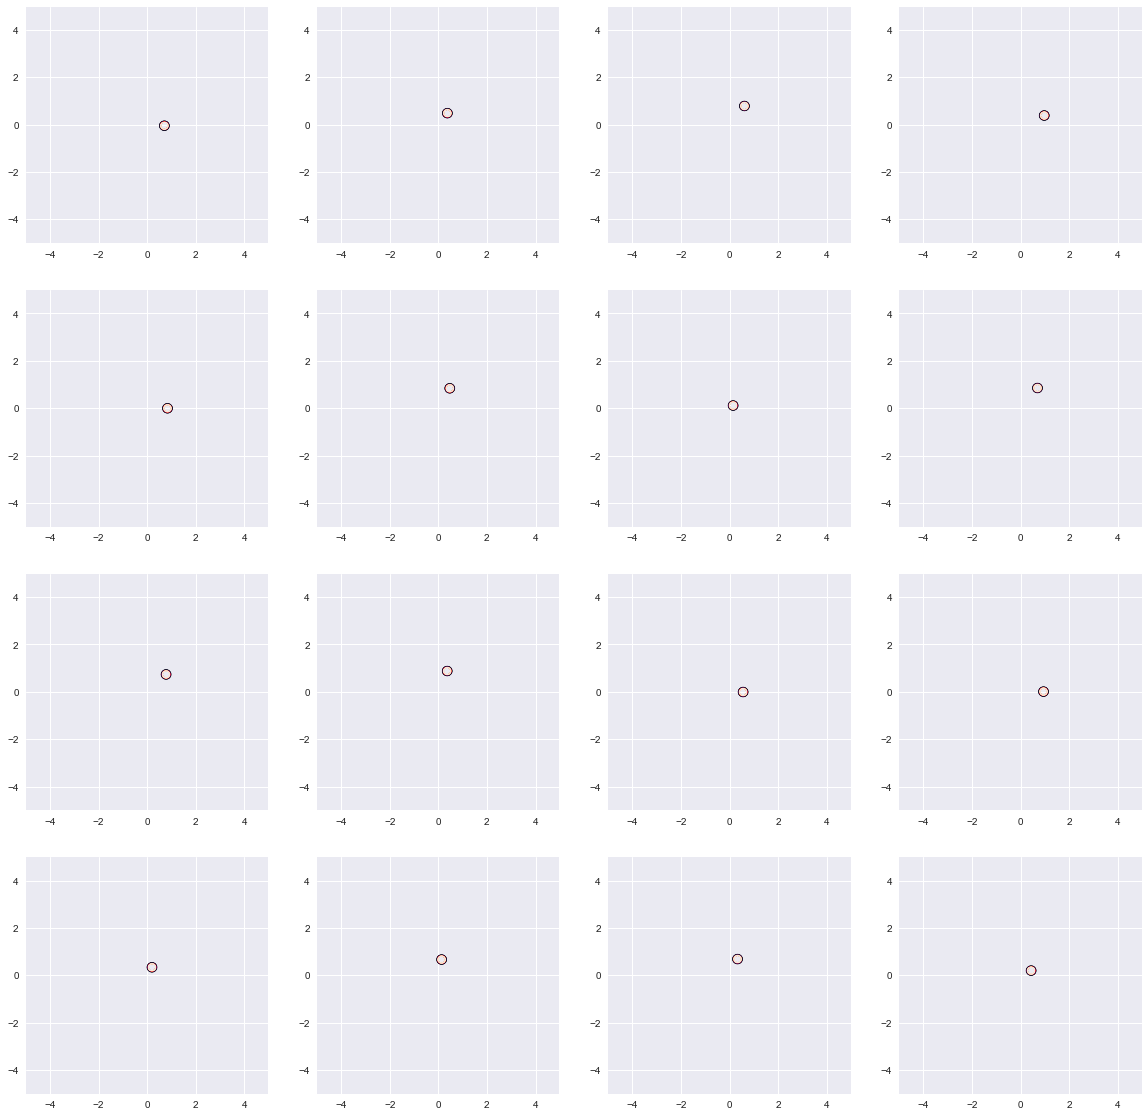

In [150]:
fig,ax=plt.subplots(4,4,figsize=(20,20))
for i in range(4):
    for j in range(4):
        plot_result(ax[i,j],150+i*4+j)

In [159]:
prediction_xy = np.ndarray([250,2])
for i in tqdm(range(250)):
    prediction_xy[i] = get_prediction(pi_reversed[i], mu_reversed[i],sigma_reversed[i])[1]

HBox(children=(IntProgress(value=0, max=250), HTML(value=u'')))

In [169]:
prediction_xy_reverse = scalers[3].inverse_transform(prediction_xy)

In [173]:
def plot_arrow(y_testdata,y_test):
    fig,ax=plt.subplots(1,figsize=(9,9))
    c = np.sum(y_testdata**2+y_test**2,axis=1)
    ax.scatter(y_testdata[:,0],y_testdata[:,1], s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)
    ax.scatter(y_test[:,0],y_test[:,1], s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  
        np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    xorigin = y_testdata[:,0].ravel()
    yorigin = y_testdata[:,1].ravel()
    dx = y_test[:,0].ravel()-y_testdata[:,0].ravel()
    dy = y_test[:,1].ravel()-y_testdata[:,1].ravel()
    print (xorigin.shape, yorigin.shape, dx.shape, dy.shape)
    ax.arrow(xorigin[2], yorigin[2], dx[2], dy[2], color = 'b')
    for i in range(y_testdata.shape[0]):
        ax.arrow(y_testdata[i,0],y_testdata[i,1],
            y_test[i,0]-y_testdata[i,0],y_test[i,1]-y_testdata[i,1],color = 'b')
#for i in range(y_testdata.shape[0]):
#    ax.arrow(y_testdata[i,0],y_testdata[i,1],
#            y_test[i,0]-y_testdata[i,0],y_test[i,1]-y_testdata[i,1],color = 'b')

In [170]:
def report_metrics(y_test_data,y_test):
    rmse = np.mean(np.sum((y_test_data - y_test)**2,axis=1)**0.5)
    pcc = scipy.stats.pearsonr(y_test_data.ravel(),y_test.ravel())
    return rmse,pcc
report_metrics(prediction_xy_reverse,y_test)

(600.8005536646447, (0.9842247165675624, 0.0))

In [162]:
y_test.shape

(250, 2)

((250,), (250,), (250,), (250,))


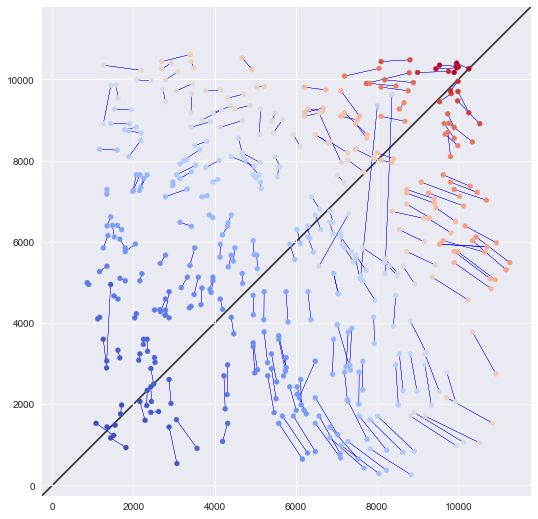

In [174]:
plot_arrow(prediction_xy_reverse,y_test)

### 思路，outlier：距离差大的是不是不确定度也大
我想后续的一个分析思路是看看误差大的样本是不是不确定度也大，如果真的相关性强的话，那我们就找到了一个很好的方法来衡量样本的预测难度